In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
assignment_path = "/content/drive/My Drive/Urban/"
sys.path.append(assignment_path)

In [ ]:
!pip install python-dateutil
!pip install pysal --quiet
from pysal.explore import esda
from pysal.lib import weights
from libpysal.weights.raster import da2W

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geo

In [ ]:
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-bfrkciqk
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-bfrkciqk


In [ ]:
import os, sys
import pandas as pd
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import warnings
from datetime import datetime
from dateutil import parser
from datetime import timedelta
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

In [ ]:
dt = pd.read_csv('/content/drive/My Drive/Urban/Data/311_City_Service_Requests_in_2020.csv', parse_dates=['ADDDATE', 'RESOLUTIONDATE', 'SERVICEDUEDATE', 'SERVICEORDERDATE', 'INSPECTIONDATE'])
#dt['RESOLUTIONDATE']= np.where((dt['RESOLUTIONDATE'].notnull()), dt['RESOLUTIONDATE'], dt['ADDDATE'])
dt=dt[dt['RESOLUTIONDATE'].notna()]
#dt['INSPECTIONDATE']= np.where((dt['INSPECTIONDATE'].notnull()), dt['INSPECTIONDATE'], datetime(2021,1,1))
#dt['DURATION']= np.log10(((dt['RESOLUTIONDATE'] - dt['ADDDATE']).dt.total_seconds())/24/60/60)
dt['DURATION']= np.log(((dt['RESOLUTIONDATE'] - dt['ADDDATE']).dt.total_seconds())/24/60/60)
dt['DURATION']= np.where((dt['DURATION']<0), 0, dt['DURATION'])
#dt['DURATION']= np.where((dt['RESOLUTIONDATE'].notnull()), dt['DURATION'], dt['ADDDATE'].dt.timestamp)
# sneak peak in the data
# dt.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
dt=dt[dt['ADDDATE']>'2020-04-01']
dt.head(2)

,X,Y,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,DURATION
82587,-77.026260,38.906209,116363,EMNPV,Emergency No-Parking Verification,PEMA- Parking Enforcement Management Administr...,DPW,1,2020-04-01 00:00:38+00:00,2020-04-01 00:01:46+00:00,2020-04-02 00:00:38+00:00,2020-04-01 00:00:38+00:00,0.0,2020-04-01 12:01:00+00:00,NaN,Closed,NaN,20-00115755,Standard,1216 10TH STREET NW,397722.50,137594.03,38.906202,-77.026258,WASHINGTON,DC,20001.0,278945.0,2.0,NaN,0.000000
82588,-76.941658,38.896954,116364,S0391,Street Cleaning,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 00:00:39+00:00,2020-05-28 09:56:04+00:00,2020-05-12 00:00:39+00:00,2020-04-01 00:00:39+00:00,0.0,2020-05-28 09:56:03+00:00,NaN,Closed,NaN,20-00115756,Standard,4214 EDSON PLACE NE,405061.24,136567.97,38.896947,-76.941656,WASHINGTON,DC,20019.0,25242.0,7.0,NaN,4.050279


In [ ]:
df = gpd.read_file('/content/drive/My Drive/Urban/Data/Census_Tracts_in_2020.geojson')
df.head(2)

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0020002,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0030001,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,H0010001,H0010002,H0010003,ALAND,AWATER,STUSAB,SUMLEV,GEOCODE,...,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry
0,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948..."
1,2,002101,11001002101,5687,5071,1037,2642,86,120,1,1185,1868,885,2586,20,115,1,39,4375,827,2149,58,100,1,816,1277,731,2110,16,95,1,25,2335,2107,228,600992,0,DC,140,11001002101,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,31,0,0,31,0,0,"POLYGON ((-77.02824 38.95813, -77.02824 38.958..."


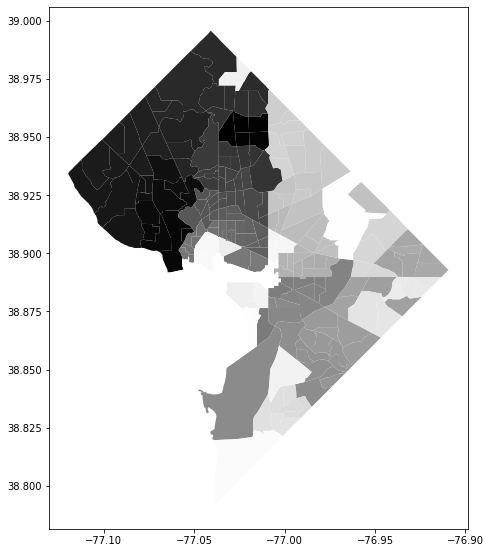

In [ ]:
df.plot(column="OBJECTID", colormap="gray", figsize=(12.8,9.6))
plt.show()

In [ ]:
gdf = gpd.GeoDataFrame(dt, geometry=gpd.points_from_xy(dt.LONGITUDE, dt.LATITUDE))
data=gdf.sjoin(df, how="left")
data.head(5)

,X,Y,OBJECTID_left,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE_left,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,DURATION,geometry,index_right,OBJECTID_right,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,...,P0040046,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN
82587,-77.026260,38.906209,116363,EMNPV,Emergency No-Parking Verification,PEMA- Parking Enforcement Management Administr...,DPW,1,2020-04-01 00:00:38+00:00,2020-04-01 00:01:46+00:00,2020-04-02 00:00:38+00:00,2020-04-01 00:00:38+00:00,0.0,2020-04-01 12:01:00+00:00,NaN,Closed,NaN,20-00115755,Standard,1216 10TH STREET NW,397722.50,137594.03,38.906202,-77.026258,WASHINGTON,DC,20001.0,278945.0,2.0,NaN,0.000000,POINT (-77.02626 38.90620),83.0,84.0,004902,11001004902,3449.0,3120.0,1749.0,782.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,36.0,0.0,0.0
82588,-76.941658,38.896954,116364,S0391,Street Cleaning,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 00:00:39+00:00,2020-05-28 09:56:04+00:00,2020-05-12 00:00:39+00:00,2020-04-01 00:00:39+00:00,0.0,2020-05-28 09:56:03+00:00,NaN,Closed,NaN,20-00115756,Standard,4214 EDSON PLACE NE,405061.24,136567.97,38.896947,-76.941656,WASHINGTON,DC,20019.0,25242.0,7.0,NaN,4.050279,POINT (-76.94166 38.89695),132.0,133.0,007803,11001007803,4590.0,4354.0,152.0,4003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,95.0,0.0,0.0
82589,-76.941355,38.884719,116365,S0391,Street Cleaning,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 00:07:48+00:00,2020-04-13 13:58:05+00:00,2020-05-12 00:07:48+00:00,2020-04-01 00:07:48+00:00,0.0,2020-04-13 13:58:03+00:00,NaN,Closed,NaN,20-00115758,Standard,4412 TEXAS AVENUE SE,405088.41,135209.80,38.884712,-76.941352,WASHINGTON,DC,20019.0,147776.0,7.0,NaN,2.531837,POINT (-76.94135 38.88471),128.0,129.0,007703,11001007703,5227.0,5016.0,86.0,4703.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,42.0,0.0,0.0
82590,-77.037392,38.912882,116366,EMNPV,Emergency No-Parking Verification,PEMA- Parking Enforcement Management Administr...,DPW,1,2020-04-01 00:19:42+00:00,2020-04-01 00:22:15+00:00,2020-04-02 00:19:42+00:00,2020-04-01 00:19:42+00:00,0.0,2020-04-01 12:20:00+00:00,NaN,Closed,NaN,20-00115760,Standard,1619 R STREET NW,396757.22,138335.16,38.912875,-77.037390,WASHINGTON,DC,20009.0,226034.0,2.0,NaN,0.000000,POINT (-77.03739 38.91287),89.0,90.0,005302,11001005302,2518.0,2288.0,1904.0,122.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,17.0,0.0,0.0
82591,-77.100097,38.939361,116367,S05SL,Streetlight Repair Investigation,Transportation Operations Administration,DDOT,1,2020-04-01 00:29:27+00:00,2020-04-02 00:15:04+00:00,2020-04-10 00:29:27+00:00,2020-04-01 00:29:27+00:00,0.0,2020-04-02 00:15:03+00:00,NaN,Closed,NaN,20-00115765,Standard,5030 SEDGWICK STREET NW,391322.23,141278.56,38.939353,-77.100094,WASHINGTON,DC,20016.0,269170.0,3.0,NaN,0.000000,POINT (-77.10009 38.93935),22.0,23.0,000904,11001000904,3148.0,2837.0,2545.0,131.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
#Calculate delta from mean by type
prop=data
propGroup=data.groupby(['SERVICECODE'])['SERVICECODE'].first()
propMean=prop.groupby(['SERVICECODE'])['DURATION'].mean()
print(propMean)
prop = pd.merge(data, propMean, on=['SERVICECODE', 'SERVICECODE'], how='left')
prop = prop.rename(columns={'DURATION_x': 'DURATION', 'DURATION_y': 'MEANSERVICEDURATION'})
prop['DURATIONDELTA']= (prop['DURATION'] - prop['MEANSERVICEDURATION'])
propG=prop.groupby(['LATITUDE', 'LONGITUDE'])['DURATIONDELTA'].mean()
prop = pd.merge(prop, propG, on=['LATITUDE', 'LONGITUDE'], how='left')
prop = prop.rename(columns={'DURATIONDELTA_x': 'DURATIONDELTA', 'DURATIONDELTA_y': 'MEANDURATIONDELTA'})
#region=prop.plot(x="LONGITUDE", y="LATITUDE", kind="scatter", c="MEANDURATIONDELTA",colormap="coolwarm", figsize=(12.8,9.6))
#states[states['NAME'] == 'District of Columbia'].plot(ax=region, color='none', edgecolor='black')
#for i in range(0,len(propGroup)):

SERVICECODE
11          0.449428
BICYCLE     2.348622
CONTREMO    3.005445
CRV02       0.000000
CRV03       0.000000
              ...   
SRC02       2.680294
TICKOM      0.000000
TRACO001    3.929814
Test01      0.000000
VACPROP     2.584888
Name: DURATION, Length: 105, dtype: float64


In [ ]:
prop[prop['SERVICECODE']=='S0031'].head(2)

,X,Y,OBJECTID_left,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE_left,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,DURATION,geometry,index_right,OBJECTID_right,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,...,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,MEANSERVICEDURATION,DURATIONDELTA,MEANDURATIONDELTA
6,-76.934637,38.874596,116369,S0031,Bulk Collection,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 04:15:43+00:00,2020-04-07 08:13:48+00:00,2020-04-07 23:59:00+00:00,2020-04-01 04:15:43+00:00,0.0,2020-04-07 08:07:00+00:00,NaN,Closed,NaN,20-00115785,Standard,1304 45TH PLACE SE,405672.05,134086.43,38.874589,-76.934635,WASHINGTON,DC,20019.0,68668.0,7.0,NaN,1.818943,POINT (-76.93463 38.87459),129.0,130.0,007707,11001007707,3927.0,3802.0,72.0,3616.0,...,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,24.0,0.0,0.0,2.318342,-0.499399,0.415967
15,-76.988437,38.924313,116379,S0031,Bulk Collection,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 07:38:12+00:00,2020-04-09 08:23:19+00:00,2020-04-09 23:59:00+00:00,2020-04-01 07:38:12+00:00,0.0,2020-04-09 08:16:00+00:00,NaN,Closed,NaN,20-00115853,Standard,1257 EVARTS STREET NE,401002.85,139603.49,38.924306,-76.988435,WASHINGTON,DC,20018.0,69551.0,5.0,NaN,2.083350,POINT (-76.98844 38.92431),161.0,162.0,009302,11001009302,1750.0,1556.0,601.0,744.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.318342,-0.234992,0.256318


In [ ]:
clusteringProp=prop

clusteringProp['DURATIONDELTA']= np.where((clusteringProp['DURATIONDELTA']==float('-inf')), 3, clusteringProp['DURATIONDELTA'])

clustermean=clusteringProp.groupby(['GEOID'])['DURATIONDELTA'].mean()
print(clustermean)
print(clusteringProp.sort_values('GEOID'))
clusteringPropMean = pd.merge(clusteringProp, clustermean, on=['GEOID'], how='left')
clusteringPropMean = clusteringPropMean.rename(columns={'DURATIONDELTA_x': 'DURATIONDELTA', 'DURATIONDELTA_y': 'CLUSTERDURATIONDELTA'})
print(clusteringPropMean)

GEOID
11001000101   -0.073065
11001000102   -0.108409
11001000201   -0.095985
11001000202   -0.153649
11001000300    0.005850
                 ...   
11001010900    0.057137
11001011001   -0.038398
11001011002   -0.020760
11001011100    0.094397
11001980000   -0.129290
Name: DURATIONDELTA, Length: 206, dtype: float64
                X          Y  ...  DURATIONDELTA MEANDURATIONDELTA
8975   -77.055964  38.907377  ...      -0.684187         -0.196015
829    -77.055423  38.908714  ...       0.517283          0.517283
830    -77.055375  38.908732  ...       0.517231          0.244640
831    -77.054973  38.908739  ...       0.373103         -0.237935
54976  -77.055257  38.909245  ...       0.305642         -0.132215
...           ...        ...  ...            ...               ...
210121 -76.970962  38.844891  ...       1.601742          0.356512
210281 -76.972454  38.843728  ...      -1.454110         -0.273394
210971 -76.974057  38.842479  ...      -1.617818         -0.588630
211749 -76.

In [ ]:
!pip install contextily
import contextily as cx

In [ ]:
#region=clusteringPropMean.plot(x="LONGITUDE", y="LATITUDE", kind="scatter", c="CLUSTERDURATIONDELTA",colormap="coolwarm", figsize=(12.8,9.6))
#df_wm = df.to_crs(epsg=3857)
#ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
#cx.add_basemap(ax)

gdfclusteringPropMean = gpd.GeoDataFrame(clusteringPropMean, geometry=gpd.points_from_xy(clusteringPropMean.LONGITUDE, clusteringPropMean.LATITUDE), crs='epsg:3857')
#region=gdfclusteringPropMean.plot(x="LONGITUDE", y="LATITUDE", kind="scatter", c="CLUSTERDURATIONDELTA",colormap="coolwarm", figsize=(12.8,9.6))
gdfclusteringPropMean.head(2)
#ax = gdfclusteringPropMean.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
#cx.add_basemap(ax)

,X,Y,OBJECTID_left,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE_left,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,DURATION,geometry,index_right,OBJECTID_right,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,...,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,MEANSERVICEDURATION,DURATIONDELTA,MEANDURATIONDELTA,CLUSTERDURATIONDELTA
0,-77.026260,38.906209,116363,EMNPV,Emergency No-Parking Verification,PEMA- Parking Enforcement Management Administr...,DPW,1,2020-04-01 00:00:38+00:00,2020-04-01 00:01:46+00:00,2020-04-02 00:00:38+00:00,2020-04-01 00:00:38+00:00,0.0,2020-04-01 12:01:00+00:00,NaN,Closed,NaN,20-00115755,Standard,1216 10TH STREET NW,397722.50,137594.03,38.906202,-77.026258,WASHINGTON,DC,20001.0,278945.0,2.0,NaN,0.000000,POINT (-77.026 38.906),83.0,84.0,004902,11001004902,3449.0,3120.0,1749.0,782.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,36.0,0.0,0.0,0.105976,-0.105976,-0.703677,-0.155361
1,-76.941658,38.896954,116364,S0391,Street Cleaning,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 00:00:39+00:00,2020-05-28 09:56:04+00:00,2020-05-12 00:00:39+00:00,2020-04-01 00:00:39+00:00,0.0,2020-05-28 09:56:03+00:00,NaN,Closed,NaN,20-00115756,Standard,4214 EDSON PLACE NE,405061.24,136567.97,38.896947,-76.941656,WASHINGTON,DC,20019.0,25242.0,7.0,NaN,4.050279,POINT (-76.942 38.897),132.0,133.0,007803,11001007803,4590.0,4354.0,152.0,4003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,95.0,0.0,0.0,3.715335,0.334944,0.422632,-0.045624


In [ ]:
blockMean = pd.merge(df, clusteringPropMean, left_on=['OBJECTID'], right_on=['OBJECTID_right'], how='left')
blockMean.head(5)

,OBJECTID,TRACT_x,GEOID_x,P0010001_x,P0010002_x,P0010003_x,P0010004_x,P0010005_x,P0010006_x,P0010007_x,P0010008_x,P0020002_x,P0020005_x,P0020006_x,P0020007_x,P0020008_x,P0020009_x,P0020010_x,P0030001_x,P0030003_x,P0030004_x,P0030005_x,P0030006_x,P0030007_x,P0030008_x,P0040002_x,P0040005_x,P0040006_x,P0040007_x,P0040008_x,P0040009_x,P0040010_x,H0010001_x,H0010002_x,H0010003_x,ALAND_x,AWATER_x,STUSAB_x,SUMLEV_x,GEOCODE_x,...,P0040050_y,P0040051_y,P0040052_y,P0040053_y,P0040054_y,P0040055_y,P0040056_y,P0040057_y,P0040058_y,P0040059_y,P0040060_y,P0040061_y,P0040062_y,P0040063_y,P0040064_y,P0040065_y,P0040066_y,P0040067_y,P0040068_y,P0040069_y,P0040070_y,P0040071_y,P0040072_y,P0040073_y,P0050001_y,P0050002_y,P0050003_y,P0050004_y,P0050005_y,P0050006_y,P0050007_y,P0050008_y,P0050009_y,P0050010_y,SHAPEAREA_y,SHAPELEN_y,MEANSERVICEDURATION,DURATIONDELTA,MEANDURATIONDELTA,CLUSTERDURATIONDELTA
0,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,0.730726,-0.586615,-0.811924,-0.104341
1,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,0.159589,-0.159589,-0.297804,-0.104341
2,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,2.584888,-2.584888,-0.608740,-0.104341
3,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,0.917174,0.618283,-0.608740,-0.104341
4,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,4.047453,1.905199,1.905199,-0.104341


In [ ]:
type(clusteringPropMean)
clusterX=clusteringPropMean.groupby(['GEOID'])['CLUSTERDURATIONDELTA'].mean()
groupMean = pd.merge(df, clusterX, on=['GEOID'], how='left')

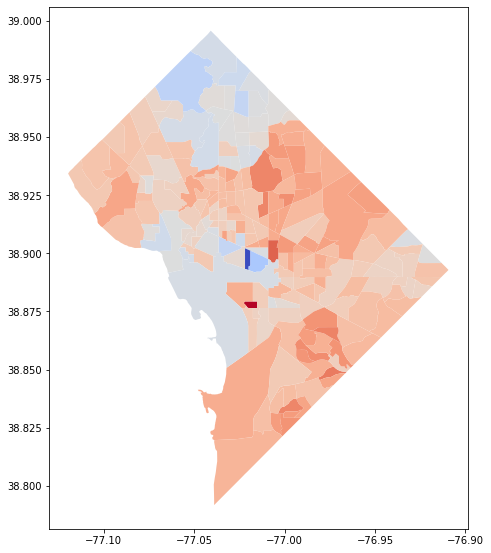

In [ ]:
groupMean.plot(column="CLUSTERDURATIONDELTA", colormap="coolwarm", figsize=(12.8,9.6))
plt.show()

In [ ]:
clusterService=clusteringPropMean.groupby(['GEOID','SERVICECODE', 'SERVICECODEDESCRIPTION','ORGANIZATIONACRONYM'], as_index=False)['MEANDURATIONDELTA'].mean()

serviceGroupMean = pd.merge(df, clusterService, on=['GEOID'], how='left')
serviceGroupMean.head(5)

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0020002,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0030001,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,H0010001,H0010002,H0010003,ALAND,AWATER,STUSAB,SUMLEV,GEOCODE,...,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry,SERVICECODE,SERVICECODEDESCRIPTION,ORGANIZATIONACRONYM,MEANDURATIONDELTA
0,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",11,Dead Animal Collection,DPW,-0.131571
1,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",CONTREMO,Container Removal,DPW,-0.075641
2,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",DCGOVTINFO,DC Government Information,OUC,-0.273483
3,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",DGSDCFLGM,DC Facilities Landscaping and Grounds Maintena...,DGS,0.157963
4,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",DMINSTIS,DMV - Vehicle Inspection Issues,DMV,-0.009556


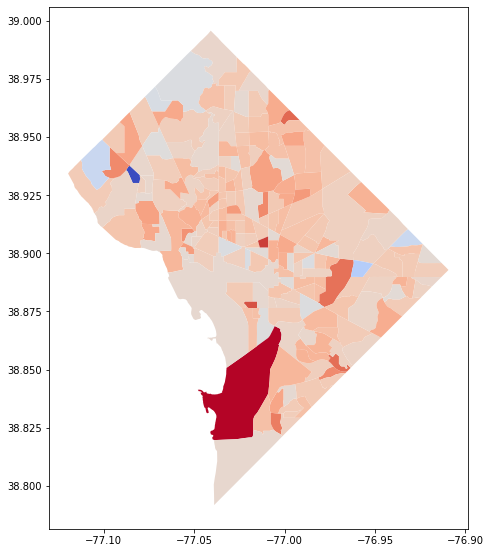

In [ ]:
serviceGroupMeanS0261=serviceGroupMean[serviceGroupMean['SERVICECODE']=='S0261']
serviceGroupMeanS0261.plot(column="MEANDURATIONDELTA", colormap="coolwarm", figsize=(12.8,9.6))
plt.show()

In [ ]:
serviceGroupMeanS0261['MEANDURATIONDELTA'].mean()

-0.020754413186602424

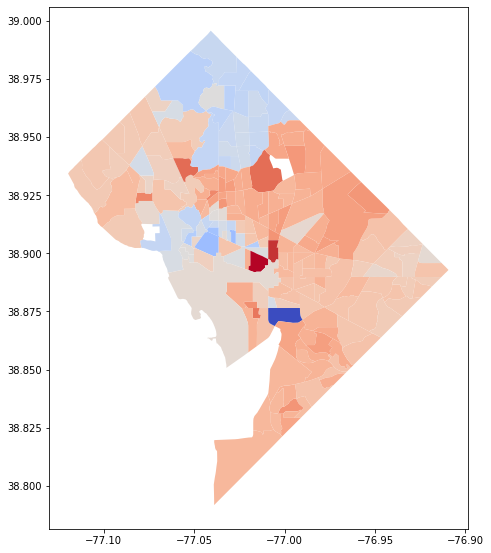

In [ ]:
serviceGroupMeanS0031=serviceGroupMean[serviceGroupMean['SERVICECODE']=='S0031']
serviceGroupMeanS0031.plot(column="MEANDURATIONDELTA", colormap="coolwarm", figsize=(12.8,9.6))
plt.show()

In [ ]:
serviceGroupMeanS0031['MEANDURATIONDELTA'].mean()

0.0003718005579600994

In [ ]:
#i=serviceGroupMean.groupby(['SERVICECODEDESCRIPTION'])['SERVICECODE'].first()
#print(i[102])
#for ii in range(0,102):
#  print(i[ii])
#  serviceGroupMeanI=serviceGroupMean[serviceGroupMean['SERVICECODE']==i[ii]]
#  serviceGroupMeanI.plot(column="MEANSERVICEDURATION", colormap="coolwarm", figsize=(12.8,9.6))
#  plt.savefig(fname='/content/drive/My Drive/Urban/Figures/' + i[ii] + '.png')

In [ ]:
i=serviceGroupMean.groupby(['SERVICECODEDESCRIPTION', 'SERVICECODE'])['ORGANIZATIONACRONYM'].first()
#i=i[i > 50]
i=i.reset_index()
print(i)
for ii in range(0,103):
  print(i.loc[[ii]])

                      SERVICECODEDESCRIPTION SERVICECODE ORGANIZATIONACRONYM
0                          Abandoned Bicycle     BICYCLE                 DPW
1    Abandoned Vehicle - On Private Property       S0003                 DPW
2     Abandoned Vehicle - On Public Property       S0000                 DPW
3                             Alley Cleaning       S0011                 DPW
4                               Alley Repair       S0016                DDOT
..                                       ...         ...                 ...
98                              Tree Removal       S0459                DDOT
99                      Utility Repair Issue       S0466                DDOT
100        Vacant Lot - Public Property Only       S0471                 DPW
101                   Wire Down/Power Outage    POWEOUTA                 OUC
102                      Yard Waste - Missed       S0476                 DPW

[103 rows x 3 columns]
  SERVICECODEDESCRIPTION SERVICECODE ORGANIZATIONACR

In [ ]:
dt19 = pd.read_csv('/content/drive/My Drive/Urban/Data/311_City_Service_Requests_in_2019.csv', parse_dates=['ADDDATE', 'RESOLUTIONDATE', 'SERVICEDUEDATE', 'SERVICEORDERDATE', 'INSPECTIONDATE'])
#dt['RESOLUTIONDATE']= np.where((dt['RESOLUTIONDATE'].notnull()), dt['RESOLUTIONDATE'], dt['ADDDATE'])
dt=dt[dt['RESOLUTIONDATE'].notna()]
#dt['INSPECTIONDATE']= np.where((dt['INSPECTIONDATE'].notnull()), dt['INSPECTIONDATE'], datetime(2021,1,1))
#dt['DURATION']= np.log10(((dt['RESOLUTIONDATE'] - dt['ADDDATE']).dt.total_seconds())/24/60/60)
dt['DURATION']= np.log(((dt['RESOLUTIONDATE'] - dt['ADDDATE']).dt.total_seconds())/24/60/60)
dt['DURATION']= np.where((dt['DURATION']<0), 0, dt['DURATION'])
#dt['DURATION']= np.where((dt['RESOLUTIONDATE'].notnull()), dt['DURATION'], dt['ADDDATE'].dt.timestamp)
# sneak peak in the data
# dt.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
dt=dt[dt['ADDDATE']>'2020-04-01']
dt.head(2)
two = dt.append(dt19, ignore_index=True)

In [ ]:
two.tail(2)

,X,Y,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,DURATION,geometry,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED
581960,-77.017162,38.877622,9542662,ILLEGALCON,DCRA - Illegal Construction,Dept of Consumer & Regulatory Affairs,DCRA,1,2019-02-22 07:08:40+00:00,2019-04-02 12:07:35+00:00,2019-04-10 17:00:00+00:00,2019-02-22 07:08:40+00:00,NaN,NaT,NaN,Voided,NaN,19-00099202,Standard,"1100 4TH STREET SW,WASHINGTON,DC,USA,20024",398511.05,134420.39,38.877614,-77.01716,WASHINGTON,DC,20024.0,307170.0,6.0,After review of the submitted service request ...,NaN,None,NaN,{B259C193-97C7-CA21-E053-532F520A1943},NaN,NaN,NaN,NaN
581961,-77.017162,38.877622,9542664,VACPROP,DCRA - Vacant Private Property Inspection,Dept of Consumer & Regulatory Affairs,DCRA,1,2019-04-02 11:57:01+00:00,2019-04-02 13:18:43+00:00,2019-08-26 11:57:00+00:00,2019-04-02 11:57:01+00:00,NaN,NaT,NaN,Voided,NaN,19-00175964,Standard,"1100 4TH STREET SW,WASHINGTON,DC,USA,20024",398511.05,134420.39,38.877614,-77.01716,WASHINGTON,DC,20024.0,307170.0,6.0,NaN,NaN,None,NaN,{B259C193-97C9-CA21-E053-532F520A1943},NaN,NaN,NaN,NaN


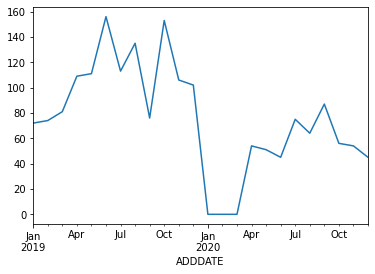

In [ ]:
twoshort=two[two['SERVICECODE'] == 'BICYCLE']
twoshort=twoshort.groupby(pd.Grouper(key='ADDDATE', freq='M'))['SERVICECODE'].count()
twoshort.plot()
plt.show()

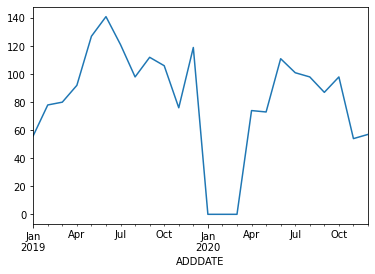

In [ ]:
twoshort=two[two['SERVICECODE'] == 'S0003']
twoshort=twoshort.groupby(pd.Grouper(key='ADDDATE', freq='M'))['SERVICECODE'].count()
twoshort.plot()
plt.show()

S0476


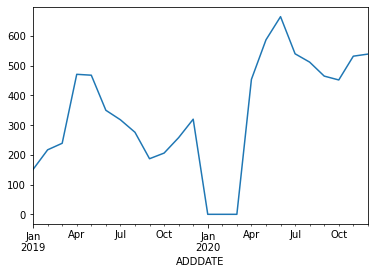

In [ ]:
i=serviceGroupMean.groupby(['SERVICECODEDESCRIPTION'])['SERVICECODE'].first()
print(i[102])
for ii in range(0,103):
  #print(i[ii])
  plt.clf()
  twoshort=two[two['SERVICECODE'] == i[ii]]
  twoshort=twoshort.groupby(pd.Grouper(key='ADDDATE', freq='M'))['SERVICECODE'].count()
  twoshort.plot()
  plt.savefig(fname='/content/drive/My Drive/Urban/Figures/' + i[ii] + '.png')

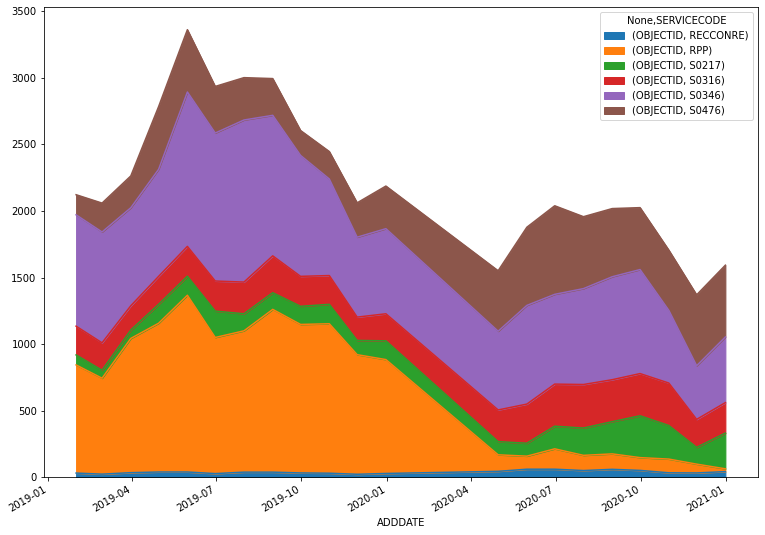

In [ ]:
twoshort=two[two['SERVICECODE'].isin(['RPP', 'S0346', 'S0316', 'S0217', 'RECCONRE', 'S0217', 'S0476'])]
twoshort=twoshort.groupby([pd.Grouper(key='ADDDATE', freq='M'),'SERVICECODE'])['OBJECTID'].count()
twoshort=twoshort.to_frame()
twoshort=twoshort.pivot_table(twoshort, ['ADDDATE'], 'SERVICECODE')
#print(twoshort)


twoshort.plot.area(figsize=(12.8,9.6))
#twoshort=two[two['SERVICECODE'].isin(['S0031'])]
#twoshort=twoshort.groupby(pd.Grouper(key='ADDDATE', freq='M'))['OBJECTID'].count()
#twoshort.plot(kind='area')
#twoshort=two[two['SERVICECODE'].isin(['RPP'])]
#twoshort=twoshort.groupby(pd.Grouper(key='ADDDATE', freq='M'))['OBJECTID'].count()
#twoshort.plot(kind='area')
#twoshort=two[two['SERVICECODE'].isin(['S0391'])]
#twoshort=twoshort.groupby(pd.Grouper(key='ADDDATE', freq='M'))['OBJECTID'].count()
#twoshort.plot(kind='area')


In [ ]:
#!pip install folium
import folium

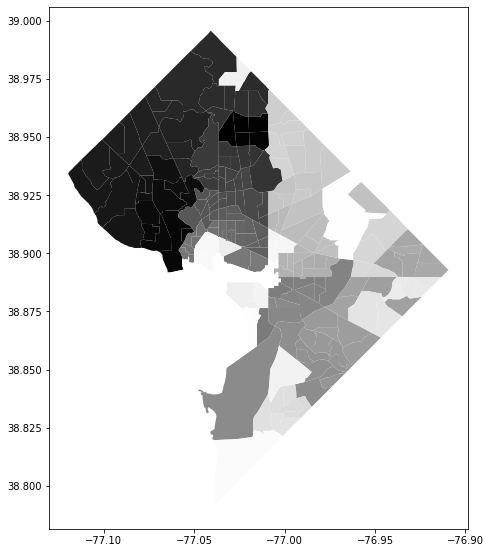

In [ ]:
df.plot(column="OBJECTID", colormap="gray", figsize=(12.8,9.6))
plt.show()

In [ ]:
#df['geometry']
#dfcal = pd.merge(df, serviceGroupMeanS0031, left_on=['OBJECTID'], right_on=['OBJECTID'], how='left')
#print(serviceGroupMeanS0261)
serviceGroupMeanS0031.head(2)

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0020002,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0030001,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,H0010001,H0010002,H0010003,ALAND,AWATER,STUSAB,SUMLEV,GEOCODE,...,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry,SERVICECODE,SERVICECODEDESCRIPTION,ORGANIZATIONACRONYM,MEANDURATIONDELTA
26,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",S0031,Bulk Collection,DPW,-0.236683
90,2,002101,11001002101,5687,5071,1037,2642,86,120,1,1185,1868,885,2586,20,115,1,39,4375,827,2149,58,100,1,816,1277,731,2110,16,95,1,25,2335,2107,228,600992,0,DC,140,11001002101,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,31,0,0,31,0,0,"POLYGON ((-77.02824 38.95813, -77.02824 38.958...",S0031,Bulk Collection,DPW,-0.206647


In [ ]:
import branca
import requests
import json


from folium.features import GeoJson, GeoJsonTooltip
serviceGroupMeanS0031.head(5)

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0020002,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0030001,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,H0010001,H0010002,H0010003,ALAND,AWATER,STUSAB,SUMLEV,GEOCODE,...,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry,SERVICECODE,SERVICECODEDESCRIPTION,ORGANIZATIONACRONYM,MEANDURATIONDELTA
26,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948...",S0031,Bulk Collection,DPW,-0.236683
90,2,002101,11001002101,5687,5071,1037,2642,86,120,1,1185,1868,885,2586,20,115,1,39,4375,827,2149,58,100,1,816,1277,731,2110,16,95,1,25,2335,2107,228,600992,0,DC,140,11001002101,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,31,0,0,31,0,0,"POLYGON ((-77.02824 38.95813, -77.02824 38.958...",S0031,Bulk Collection,DPW,-0.206647
154,3,002102,11001002102,5099,4599,901,2910,50,87,0,651,1074,805,2856,14,83,0,40,3984,741,2340,44,79,0,433,735,674,2300,13,75,0,28,2221,1959,262,725975,0,DC,140,11001002102,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,145,0,0,0,0,0,145,0,0,145,0,0,"POLYGON ((-77.01997 38.95819, -77.01997 38.958...",S0031,Bulk Collection,DPW,-0.241680
213,4,002201,11001002201,3485,3138,973,1722,21,94,2,326,683,864,1687,3,85,2,14,2755,742,1444,13,75,2,248,485,671,1427,1,73,2,11,1229,1141,88,415173,0,DC,140,11001002201,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,6,0,0,0,0,0,0,0,0,"POLYGON ((-77.02743 38.95188, -77.02740 38.951...",S0031,Bulk Collection,DPW,-0.212439
278,5,002202,11001002202,3339,2957,619,1636,48,57,3,594,1003,548,1594,8,54,0,22,2556,496,1310,38,57,3,393,672,452,1285,8,54,0,17,1454,1273,181,698895,566,DC,140,11001002202,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0,4,0,0,"POLYGON ((-77.01968 38.95209, -77.01963 38.951...",S0031,Bulk Collection,DPW,-0.241640


In [ ]:
!pip install IPython

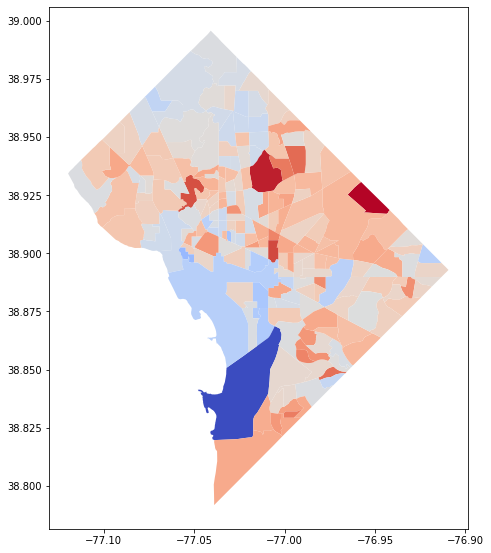

In [ ]:
DPWGroupMean=serviceGroupMean[serviceGroupMean['ORGANIZATIONACRONYM']=='DPW']
#DPWGroupMean=DPWGroupMean[DPWGroupMean['GEOID']=='11001002002']
#DPWGroupMean=DPWGroupMean.groupby(['GEOID'], as_index=False)['MEANDURATIONDELTA'].mean()
DPWGroupMean=DPWGroupMean.groupby(['GEOID', 'ORGANIZATIONACRONYM'], as_index=False)['MEANDURATIONDELTA'].mean()
DPWMean = pd.merge(df, DPWGroupMean, on=['GEOID'], how='left')
DPWMean.plot(column="MEANDURATIONDELTA", colormap="coolwarm", figsize=(12.8,9.6))
plt.show()

In [ ]:
wra=gpd.GeoDataFrame(df)
map = folium.Map(location=[38.877622, -77.017162], zoom_start=11)

layer_geom = folium.FeatureGroup(name='layer',control=False)

layer = folium.FeatureGroup(name='layer')

for index, row in DPWMean.iterrows():
    pop = folium.GeoJson(
        row['geometry'],
        name=('{}{}'.format(row['OBJECTID'], row['ORGANIZATIONACRONYM'])),
        overlay=True
    )
    folium.Popup('<a href={}_{}.html>Info</a>'.format(row['OBJECTID'], row['ORGANIZATIONACRONYM'])).add_to(pop)
    pop.add_to(layer)

choro=folium.Choropleth(
    geo_data=DPWMean,
    name="choropleth",
    data=DPWMean,
    columns=["OBJECTID", "MEANDURATIONDELTA"],
    key_on="feature.properties.OBJECTID",
    fill_color="RdYlBu_r",
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name="Avg Service Wait",
    highlight=True
).add_to(map)

layer.add_to(map)

map
outfile = "/content/drive/My Drive/Urban/dpw.html"
map.save(outfile)

In [ ]:
df.head(1)

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0020002,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0030001,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,H0010001,H0010002,H0010003,ALAND,AWATER,STUSAB,SUMLEV,GEOCODE,...,P0040047,P0040048,P0040049,P0040050,P0040051,P0040052,P0040053,P0040054,P0040055,P0040056,P0040057,P0040058,P0040059,P0040060,P0040061,P0040062,P0040063,P0040064,P0040065,P0040066,P0040067,P0040068,P0040069,P0040070,P0040071,P0040072,P0040073,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN,geometry
0,1,002002,11001002002,4072,3647,1116,1751,27,84,0,669,1022,1033,1722,4,83,0,21,3198,855,1505,24,71,0,470,701,805,1490,4,70,0,8,1532,1394,138,849376,0,DC,140,11001002002,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,32,0,0,32,0,0,"POLYGON ((-77.03642 38.94975, -77.03643 38.948..."


In [ ]:
from sklearn.cluster import OPTICS

In [ ]:
geogroup=dt[dt['ORGANIZATIONACRONYM']=='DPW']
geogroup=geogroup.groupby(['LATITUDE', 'LONGITUDE'])[['LATITUDE','LONGITUDE']].first()

In [ ]:
geocoor=OPTICS(max_eps=15, min_samples=7).fit(geogroup)

cluster_labels = geocoor.labels_
num_clusters = len(set(cluster_labels))
print(geocoor.core_distances_)
geo2=dt[['LATITUDE', 'LONGITUDE']]
#print(dt[['LATITUDE','LONGITUDE']])
#geocoor.fit_predict(geo2.head(7))

labels = geocoor.labels_

numclusters = len(np.unique(labels) )
numnoise = np.sum(np.array(labels) == -1, axis=0)

print('Clusters: %d' % numclusters)
print('Noise: %d' % numnoise)

[0.00905093 0.00834749 0.00513166 ... 0.00093753 0.00089055 0.00116559]
Clusters: 2475
Noise: 33891


In [ ]:
clusteradd=geogroup
dta=dt
clusteradd['CLUSTER']= pd.Series(labels, index=clusteradd.index)
clusteradd=clusteradd['CLUSTER']
clustering = pd.merge(dta, clusteradd, on=['LATITUDE', 'LONGITUDE'], how='left')

In [ ]:
DPWclustering=clustering[clustering['ORGANIZATIONACRONYM']=='DPW']
DPWclustering.head(2)

,X,Y,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,DURATION,geometry,CLUSTER
0,-77.026260,38.906209,116363,EMNPV,Emergency No-Parking Verification,PEMA- Parking Enforcement Management Administr...,DPW,1,2020-04-01 00:00:38+00:00,2020-04-01 00:01:46+00:00,2020-04-02 00:00:38+00:00,2020-04-01 00:00:38+00:00,0.0,2020-04-01 12:01:00+00:00,NaN,Closed,NaN,20-00115755,Standard,1216 10TH STREET NW,397722.50,137594.03,38.906202,-77.026258,WASHINGTON,DC,20001.0,278945.0,2.0,NaN,0.000000,POINT (-77.02626 38.90620),-1.0
1,-76.941658,38.896954,116364,S0391,Street Cleaning,SWMA- Solid Waste Management Admistration,DPW,1,2020-04-01 00:00:39+00:00,2020-05-28 09:56:04+00:00,2020-05-12 00:00:39+00:00,2020-04-01 00:00:39+00:00,0.0,2020-05-28 09:56:03+00:00,NaN,Closed,NaN,20-00115756,Standard,4214 EDSON PLACE NE,405061.24,136567.97,38.896947,-76.941656,WASHINGTON,DC,20019.0,25242.0,7.0,NaN,4.050279,POINT (-76.94166 38.89695),249.0


In [ ]:
gdfDPWclustering = gpd.GeoDataFrame(DPWclustering, geometry=gpd.points_from_xy(DPWclustering.LONGITUDE, DPWclustering.LATITUDE), crs='EPSG:4326')
DPWclusteringGDF=df.sjoin(gdfDPWclustering, how="right")

#DPWClusteringMean=(DPWclusteringGDF.groupby(['GEOID', 'CLUSTER'], as_index=False)['DURATION'].mean())
print(DPWclusteringGDF['OBJECTID_left'])

0          84.0
1         133.0
2         129.0
3          90.0
6         130.0
          ...  
213245    137.0
213246    185.0
213250     67.0
213251    109.0
213252    164.0
Name: OBJECTID_left, Length: 147078, dtype: float64


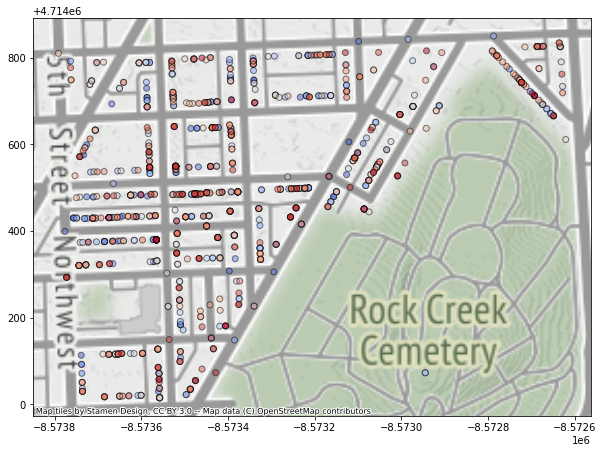

In [ ]:
dfMap = DPWclusteringGDF.to_crs(epsg=3857)
i=DPWclusteringGDF[DPWclusteringGDF['OBJECTID_left']==5]
topMap = i.to_crs(epsg=3857)
mapper = topMap.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', c="DURATION",colormap="coolwarm")
cx.add_basemap(mapper, zoom=15)

In [ ]:
i=serviceGroupMean.groupby(['SERVICECODEDESCRIPTION'])['SERVICECODE'].first()
i=DPWclusteringGDF[DPWclusteringGDF['OBJECTID_right']==ii]

for ii in range(5,207):
  i=DPWclusteringGDF[DPWclusteringGDF['OBJECTID_left']==ii]
  topMap = i.to_crs(epsg=3857)
  mapper = topMap.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', c="DURATION",colormap="coolwarm")
  try:
    cx.add_basemap(mapper)
  except:
    cx.add_basemap(mapper, zoom=15)
    plt.savefig(fname='/content/drive/My Drive/Urban/Maps/' + str(ii) + '.png')
#  finally:
    #plt.savefig(fname='/content/drive/My Drive/Urban/Maps/' + str(ii) + '.png')

Output hidden; open in https://colab.research.google.com to view.

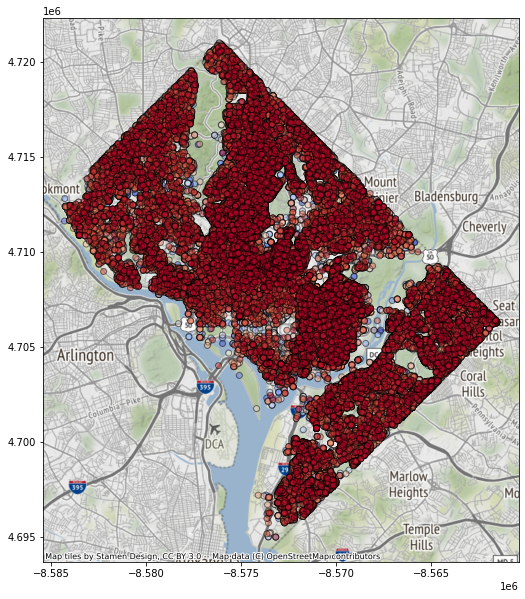

In [ ]:
#region=clusteringPropMean.plot(x="LONGITUDE", y="LATITUDE", kind="scatter", c="CLUSTERDURATIONDELTA",colormap="coolwarm", figsize=(12.8,9.6))
#df_wm = df.to_crs(epsg=3857)
#ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
#cx.add_basemap(ax)

gdfclusteringPropMean = gpd.GeoDataFrame(clusteringPropMean, geometry=gpd.points_from_xy(clusteringPropMean.LONGITUDE, clusteringPropMean.LATITUDE), crs='EPSG:4326')
#region=gdfclusteringPropMean.plot(x="LONGITUDE", y="LATITUDE", kind="scatter", c="CLUSTERDURATIONDELTA",colormap="coolwarm", figsize=(12.8,9.6))
gdfclusteringPropMean.head(2)
df_wm = gdfclusteringPropMean.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', c="CLUSTERDURATIONDELTA",colormap="coolwarm")
cx.add_basemap(ax)

In [92]:
for ii in range(1,207):
  worst=DPWclusteringGDF[DPWclusteringGDF['OBJECTID_left']==ii].sort_values(by='DURATION', ascending=False)
  worst=worst[['STREETADDRESS', 'SERVICECODE', 'SERVICECODEDESCRIPTION', 'ADDDATE', 'DURATION']]
  filename="/content/drive/My Drive/Urban/HTML/" + str(ii) +  "_DPW.html"
  fi = open(filename, "w")
  fi.write("<HTML><HEAD><TITLE>" + str(5) + "</TITLE></HEAD><BODY><img src='MAPS/" + str(ii) + ".png' alt='Census Tract " + str(ii) +  " Map'></img><H1>Most Overdue Work</H1><TABLE border=1><TR>")
  fi.write("<TD>Street</TD><TD>Code</TD><TD>Description</TD><TD>Add Date</TD><TD>Duration</TD></TR>")
   
  for y in range(1,6):
    try: #Being lazy here as this is a prototype/proof of concept
      fi.write("<TR><TD>" + str(worst.iloc[[y]]['STREETADDRESS'].to_string(index=False)) + "</TD><TD>" + str(worst.iloc[[y]]['SERVICECODE'].to_string(index=False)) + "</TD><TD>" + str(worst.iloc[[y]]['SERVICECODEDESCRIPTION'].to_string(index=False)) + "</TD><TD>" + str(worst.iloc[[y]]['ADDDATE'].to_string(index=False)) + "</TD><TD>" + str(worst.iloc[[y]]['DURATION'].to_string(index=False)) + "</TD></TR>")
    except:
      None
  
  fi.write("</TABLE><a href='dpw.html'>Back</a></BODY></HTML>")
  fi.close()

#print("Street " + worst.iloc[[0]]['STREETADDRESS'].to_string(index=False) + "yo")